In [2]:
import multiprocessing
import tqdm

import numpy as np
import scipy.stats as st
import numba

import biocircuits

# Plotting modules
import matplotlib.pyplot as plt
import bokeh.io
import bokeh.plotting

In [3]:
def muestraDiscreta(prob):
    #Al azar da un index con probabilidad prob
    #Numero al azar
    n = np.random.rand()
    #Dar indice
    i = 0
    pSum = 0.0
    while pSum < n:
        pSum = pSum + prob[i]
        i = i+1
    return i-1

prob1 = np.array([0.1,0.3,0.4,0.05,0.15,1])

In [4]:
def gillespieChoice(propensitiesFunction,propensities,population,time,args = ()):
    """Nos da la reaccion seleccionada al azar y el tiempo que se demoro en
    hacer la reaccion.
    """
    #Calcular propensities. 
    propensitiesFunction(propensities,population,time,*args)
    
    #Suma de las propensities.
    propsSum = propensities.sum()

    
    
    #Dar nuevo tiempo exponencial.
    t = np.random.exponential(1.0/propsSum)
    
    #Probabilidad discreta de cada reaccion:
    rDProb = propensities/propsSum
    
    #Sacar una reaccion de la distribucion
    reaction = muestraDiscreta(rDProb)
    
    return reaction, t


In [5]:
def gillespieSim1(propensityFunction, 
                  update,population0, 
                  timePoints, 
                  args =()):
    
    #Inicializar el output.
    outSol = np.empty((len(timePoints),update.shape[1]), dtype = int)
    
    #Inicializar y realizar la simulacion.
    timei = 1
    i = 0
    t = timePoints[0]
    population = population0.copy()
    outSol[0,:] = population
    propensities = np.zeros(update.shape[0])
    
    while i < len(timePoints):
        while t < timePoints[timei]:
            #Sacar evento y tiempo que paso para el evento.
            evento, dt = gillespieChoice(propensityFunction, propensities, population, t, args)
            
            #Actualizar la poblacion y el tiempo
            poblacionAnterior = population.copy()
            population += update[evento,:]
            
            t = t + dt
        #Actualizar indice
        i = np.searchsorted(timePoints >t,True)
        outSol[timei: min(i,len(timePoints))] = poblacionAnterior
        timei = i
    return outSol

In [6]:
simple_update = np.array(
    [
        [1, 0],  # Make mRNA transcript
        [-1, 0],  # Degrade mRNA
        [0, 1],  # Make protein
        [0, -1],  # Degrade protein
    ],
    dtype=int,
)

def simple_propensity(propensities, population, t, beta_m, beta_p, gamma):
    """Updates an array of propensities given a set of parameters
    and an array of populations.
    """
    # Unpack population
    m, p = population

    # Update propensities
    propensities[0] = beta_m  # Make mRNA transcript
    propensities[1] = m  # Degrade mRNA
    propensities[2] = beta_p * m  # Make protein
    propensities[3] = gamma * p  # Degrade protein


In [7]:
# Specify parameters for calculation
args = (10.0, 10.0, 0.4)
time_points = np.linspace(0, 50, 101)
population_0 = np.array([0, 0], dtype=int)
size = 500

# Seed random number generator for reproducibility
np.random.seed(42)

# Initialize output array
samples = np.empty((size, len(time_points), 2), dtype=int)

# Run the calculations
for i in tqdm.tqdm(range(size)):
    samples[i, :, :] = gillespieSim1(
        simple_propensity, simple_update, population_0, time_points, args=args
    )  



100%|██████████| 500/500 [04:15<00:00,  1.96it/s]


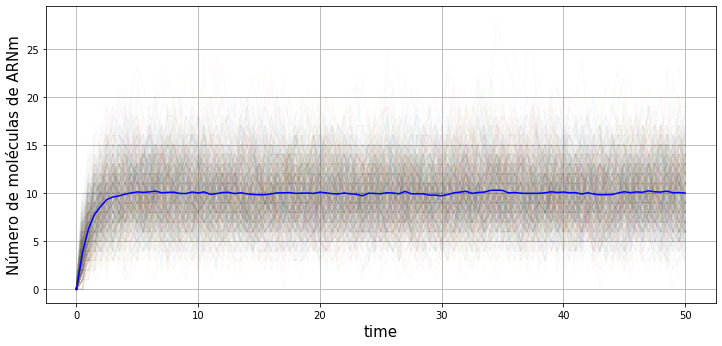

In [8]:
plt.figure(figsize = (12,12))
plt.subplot(2,1,1)
plt.xlabel("time",fontsize=15)
plt.ylabel("Número de moléculas de ARNm",fontsize=15)
plt.grid()
for i in range(size):
    plt.plot(time_points,samples[i,:,0],alpha=0.02)
plt.plot(time_points,samples[:, :, 0].mean(axis=0),color ="blue")

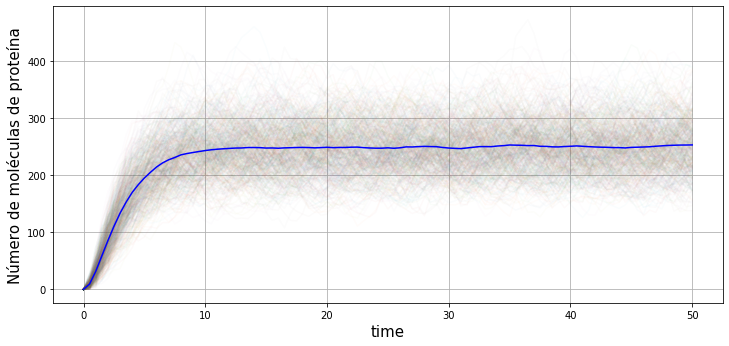

In [9]:
plt.figure(figsize = (12,12))
plt.subplot(2,1,2)
plt.xlabel("time",fontsize=15)
plt.ylabel("Número de moléculas de proteína",fontsize=15)
plt.grid()
for i in range(size):
    plt.plot(time_points,samples[i,:,1],alpha=0.02,)
plt.plot(time_points,samples[:, :, 1].mean(axis=0),color ="blue")